# Test

Import usefull packages + the njord library. For installations details please refer to README file. 

In [16]:
import ccxt
import time
import njord as nj
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load data.

Here we load all the data that is available for binance.

In [2]:
# Set the hyper parameter.
period = "1d"
exchange = ccxt.binance()
markets = exchange.loadMarkets()

In [18]:
ohlcv = {}

MAX_COUNTER = 30
counter = 1

for market in markets.keys():
    
    # Start the timer.
    time_start = time.time()
    
    # Load and process the data.
    data = exchange.fetchOhlcv(market, "1h")
    df = pd.DataFrame(data, columns=["time", "o", "h", "l", "c", "v"])
    df = df.set_index("time")
    df.index = pd.to_datetime(df.index, unit="ms")
    ohlcv[market] = df
    
    # End the timer.
    elapsed = int( 1000 * ( time.time() - time_start ))
    
    # Display.
    print("Load market data {}, elapsed time = {} [ms]".format(market, elapsed))
    
    # Check the counter.
    counter += 1
    if counter > MAX_COUNTER:
        break

Load market data ETH/BTC, elapsed time = 329 [ms]
Load market data LTC/BTC, elapsed time = 309 [ms]
Load market data BNB/BTC, elapsed time = 304 [ms]
Load market data NEO/BTC, elapsed time = 306 [ms]
Load market data QTUM/ETH, elapsed time = 306 [ms]
Load market data EOS/ETH, elapsed time = 307 [ms]
Load market data SNT/ETH, elapsed time = 305 [ms]
Load market data BNT/ETH, elapsed time = 306 [ms]
Load market data BCH/BTC, elapsed time = 409 [ms]
Load market data GAS/BTC, elapsed time = 338 [ms]
Load market data BNB/ETH, elapsed time = 381 [ms]
Load market data BTC/USDT, elapsed time = 320 [ms]
Load market data ETH/USDT, elapsed time = 402 [ms]
Load market data HSR/BTC, elapsed time = 408 [ms]
Load market data OAX/ETH, elapsed time = 403 [ms]
Load market data DNT/ETH, elapsed time = 308 [ms]
Load market data MCO/ETH, elapsed time = 614 [ms]
Load market data ICN/ETH, elapsed time = 408 [ms]
Load market data MCO/BTC, elapsed time = 311 [ms]
Load market data WTC/BTC, elapsed time = 303 [m

## Build the batch.

We now have to build the batch, i.e. a feature array X with its associated targets Y. 

In [40]:
import njord as nj

# Set the initial list.
X = []
Y = []

# Loop on the markets.
for market, data in ohlcv.items():
    batch = nj.Batch(data, 16, 1)
    x, y = batch.build(target="c", method="pct")
    y = 1.0 * ( y > 0.0 ).reshape(-1,1)
    X.append(x)
    Y.append(y)

In [41]:
# Build the entire batch.
X_tr = np.vstack(X)
Y_tr = np.vstack(Y)

# Display features information.
print("\nTraining Features info:")
print("X_tr shape = {}".format(X_tr.shape))
print("X_tr mean  = {}".format(X_tr.mean()))
print("X_tr std   = {}".format(X_tr.std()))
print("X_tr max   = {}".format(X_tr.max()))
print("X_tr min   = {}".format(X_tr.min()))
print("\nTest Features info:")
print("Y_tr shape = {}".format(Y_tr.shape))
print("Y_tr mean  = {}".format(Y_tr.mean()))
print("Y_tr std   = {}".format(Y_tr.std()))


Training Features info:
X_tr shape = (0, 16, 5)
X_tr mean  = nan
X_tr std   = nan


/Users/mdhoffschmidt/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  
/Users/mdhoffschmidt/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/mdhoffschmidt/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/mdhoffschmidt/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/mdhoffschmidt/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation maximum which has no identity

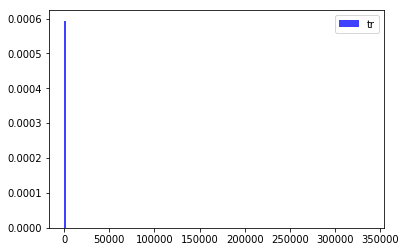

In [24]:
# Histogram: Train and test Features.
hist_X_tr = plt.hist(X_tr.reshape(-1, 1), 200, density=True, facecolor="b", alpha=0.75, label="tr")
plt.legend()
plt.show()

## Training

Train a model with keras.

In [25]:
# Import usefull packages.
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import GRU
from keras import optimizers
import keras.backend as K

In [26]:
# Define the precision.
def P(y_true, y_pred):
    """Function that computes the precision.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Define the recall.
def R(y_true, y_pred):
    """Function that computes the recall.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [36]:
# Reshape the training dataset.
X_train = X_tr #.reshape(X_tr.shape[0], -1)
Y_train = Y_tr #.reshape(X_tr.shape[0], -1)

# Build the model.
model = Sequential()
model.add(GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(GRU(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(units=1, activation="sigmoid"))

# Set the optimizer.
optimizer = optimizers.Adam(lr=0.00025) #, rho=0.95, epsilon=1.0E-6, decay=0.0)

# Compile the model.
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=[R, P])

# Set the training parameters.
params = {
    "epochs": 100,
    "batch_size": 256,
    "verbose": 1,
    "shuffle": True,
    "validation_split": 0.5
}

# Train the model.
history = model.fit(X_train, Y_train, **params)

# Training finished.
print("Training finished")

Train on 7225 samples, validate on 7226 samples
Epoch 1/100
7225/7225 [==============================] - 3s 420us/step - loss: 0.6931 - R: 0.4061 - P: 0.4844 - val_loss: 0.6919 - val_R: 0.0138 - val_P: 0.5394
Epoch 2/100
7225/7225 [==============================] - 1s 194us/step - loss: 0.6926 - R: 0.0877 - P: 0.4364 - val_loss: 0.6908 - val_R: 0.0000e+00 - val_P: 0.0000e+00
Epoch 3/100
7225/7225 [==============================] - 1s 199us/step - loss: 0.6924 - R: 0.0135 - P: 0.1776 - val_loss: 0.6907 - val_R: 0.0012 - val_P: 0.1063
Epoch 4/100
7225/7225 [==============================] - 1s 196us/step - loss: 0.6926 - R: 0.1014 - P: 0.3907 - val_loss: 0.6909 - val_R: 0.0058 - val_P: 0.3921
Epoch 5/100
7225/7225 [==============================] - 1s 196us/step - loss: 0.6922 - R: 0.0213 - P: 0.2707 - val_loss: 0.6918 - val_R: 0.1973 - val_P: 0.4772
Epoch 6/100
7225/7225 [==============================] - 1s 193us/step - loss: 0.6924 - R: 0.1004 - P: 0.4323 - val_loss: 0.6902 - val_R: 0

7225/7225 [==============================] - 2s 249us/step - loss: 0.6859 - R: 0.3125 - P: 0.5527 - val_loss: 0.6889 - val_R: 0.2872 - val_P: 0.5154
Epoch 52/100
7225/7225 [==============================] - 2s 235us/step - loss: 0.6860 - R: 0.3245 - P: 0.5533 - val_loss: 0.6888 - val_R: 0.3124 - val_P: 0.5192
Epoch 53/100
7225/7225 [==============================] - 2s 208us/step - loss: 0.6862 - R: 0.2501 - P: 0.5648 - val_loss: 0.6889 - val_R: 0.2939 - val_P: 0.5174
Epoch 54/100
7225/7225 [==============================] - 2s 213us/step - loss: 0.6860 - R: 0.2973 - P: 0.5575 - val_loss: 0.6890 - val_R: 0.3218 - val_P: 0.5154
Epoch 55/100
7225/7225 [==============================] - 2s 209us/step - loss: 0.6863 - R: 0.3381 - P: 0.5415 - val_loss: 0.6892 - val_R: 0.2773 - val_P: 0.5172
Epoch 56/100
7225/7225 [==============================] - 2s 220us/step - loss: 0.6860 - R: 0.3279 - P: 0.5484 - val_loss: 0.6887 - val_R: 0.2936 - val_P: 0.5197
Epoch 57/100
7225/7225 [=================

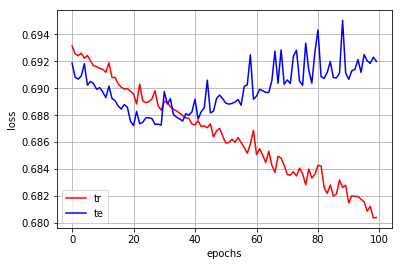

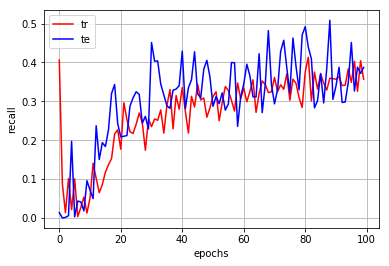

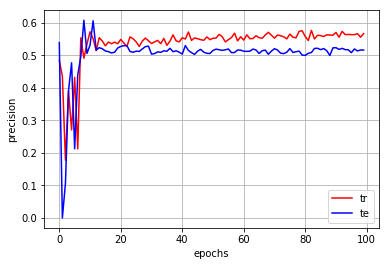

In [37]:
# Figure: loss vs epochs.
plt.figure()
plt.plot(history.history["loss"], label="tr", color="r")
plt.plot(history.history["val_loss"], label="te", color="b")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.grid()
plt.show()

# Figure: recall vs. epochs.
plt.figure()
plt.plot(history.history["R"], label="tr", color="r")
plt.plot(history.history["val_R"], label="te", color="b")
plt.xlabel("epochs")
plt.ylabel("recall")
plt.legend()
plt.grid()
plt.show()

# Figure: precision vs. epochs.
plt.figure()
plt.plot(history.history["P"], label="tr", color="r")
plt.plot(history.history["val_P"], label="te", color="b")
plt.xlabel("epochs")
plt.ylabel("precision")
plt.legend()
plt.grid()
plt.show()

In [43]:
# Evaluate the model on th train set.
eval_tr = model.evaluate(X_train, Y_train, verbose=2)

# Display the results.
print("Evaluate model on the training set: \n {}".format(eval_tr))

Evaluate model on the training set: 
 [0.6857581778171854, 0.38345177561657195, 0.5567286345638806]
